In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append(r"C:\Users\Shadow\PycharmProjects\StageObjet2020\PurePython")

from OverdampedLangevin3D import Langevin3D 
from InertialLangevin3D import InertialLangevin3D

from mpl_toolkits import mplot3d
from scipy.signal import correlate

import matplotlib.gridspec as gridspec


import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 140

mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["lines.markeredgecolor"] = "k"
mpl.rcParams["lines.markeredgewidth"] = 0.2
mpl.rcParams["figure.dpi"] = 130
from matplotlib import rc
rc('font', family='serif')
#rc('text', usetex=True)
rc('xtick', labelsize='x-small')
rc('ytick', labelsize='x-small')

# Langevin 3D, bulk, free particule

## I. Without inertia

<font color='blue'> Trajectory in 1D is writting by :

\begin{equation}
x(t+dt) = x(t) + a(x_{t}) \Delta B_{t} 
\end{equation}

$\underline{Creation~of~\textit{Langevin3D}~class.}$

$\textbf{Attributes of Langevin3D}$:
- dt: Time step [s].
- Nt: Number of time points.
- R: Radius of particule [m].
- eta: Fluid viscosity (default = 0.001 [Pa/s]).
- T: Temperature (default = 300 [k]).
- x0: Initial position of particule (default = (0,0,0) [m]).

$\textbf{Methodes of Langevin3D}$:

- Trajectory(output=False, Nt=None)
- plotTrajectory() 
- MSD1D(axis, output=False, plot=False)
- MSD3D(output=False, plot=False) 
- speedDistribution1D(axis, nbTimesIntervalle=1, bins=50, output=False, plot=False) 
- dXDistribution1D(axis, nbTimesIntervalle=1, bins=50, output=False, plot=False)</font>





### I.1 Trajectories

In [2]:
dt = 0.01
Nt = 500000
R = 1e-6
langevin3D = Langevin3D(dt, Nt, R)
langevin3D.trajectory()


<ipython-input-3-558f66f45d52>:15: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


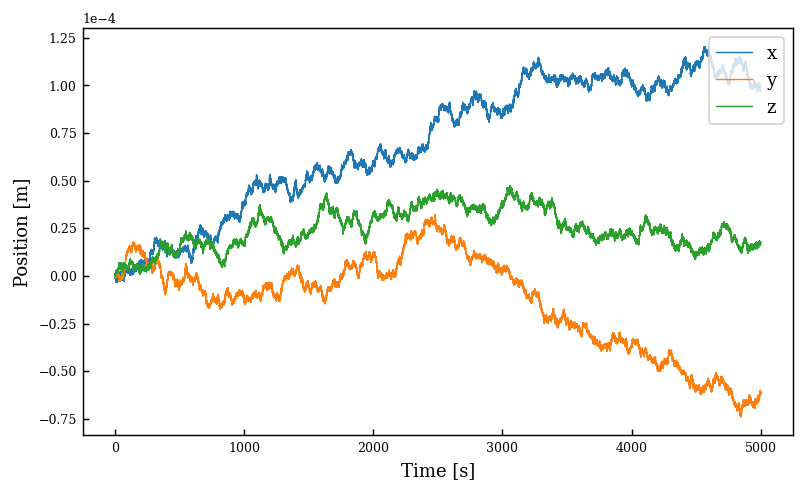

In [3]:
def cm2Inch(cm):
    inch = cm / 2.54
    return inch

w = cm2Inch(21 - 5)
h = cm2Inch((21 - 5)/1.618)
fig = plt.figure(constrained_layout=True, figsize=(w,h))
plt.plot(langevin3D.t, langevin3D.x, linewidth=0.8, label="x")
plt.plot(langevin3D.t, langevin3D.y, linewidth=0.8, label="y")
plt.plot(langevin3D.t, langevin3D.z, linewidth=0.8, label="z")
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.ticklabel_format(axis="y", style="sci", scilimits=(-2, 2))
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()
# plt.savefig("trajOverdampedBulk.pdf")

### I.2 Mean square displacement 1D

<font color='blue'> The MSD 1D is compute like this :
\begin{equation}
<(x(t+dt)-x(t))^{2}> = \frac{1}{N} \sum (x(t+dt)-x(t))^{2}
\end{equation}</font>



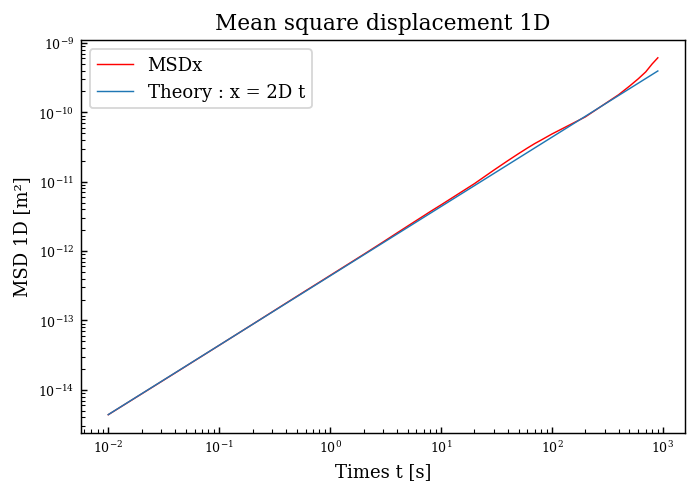

In [4]:
langevin3D.MSD1D("x", plot=True)

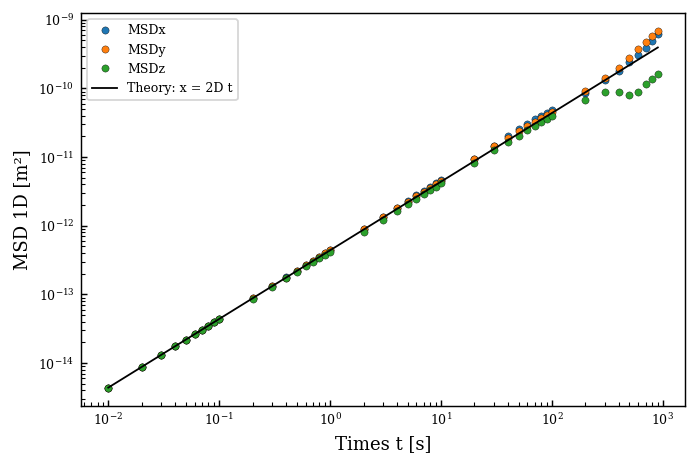

In [5]:
MSDx = langevin3D.MSD1D("x", output=True)
MSDy = langevin3D.MSD1D("y", output=True)
MSDz = langevin3D.MSD1D("z", output=True)

MSD1D = (2 * langevin3D.kb * langevin3D.T / langevin3D.gamma) * langevin3D.t[langevin3D.list_dt_MSD]

plt.loglog(langevin3D.t[langevin3D.list_dt_MSD],
            MSDx,
            "o", markersize=4,
            label="MSDx",
            )
plt.loglog(langevin3D.t[langevin3D.list_dt_MSD],
            MSDy,
            "o", markersize=4,
            label="MSDy",
            )
plt.loglog(langevin3D.t[langevin3D.list_dt_MSD],
            MSDz,
            "o", markersize=4,
            label="MSDz",
            )
plt.plot(langevin3D.t[langevin3D.list_dt_MSD],
         MSD1D,
         linewidth=1,
         color="black",
         label="Theory: x = 2D t",
        )
plt.xlabel("Times t [s]")
plt.ylabel("MSD 1D [m²]")
plt.legend(fontsize='x-small', loc='upper left')
plt.show()

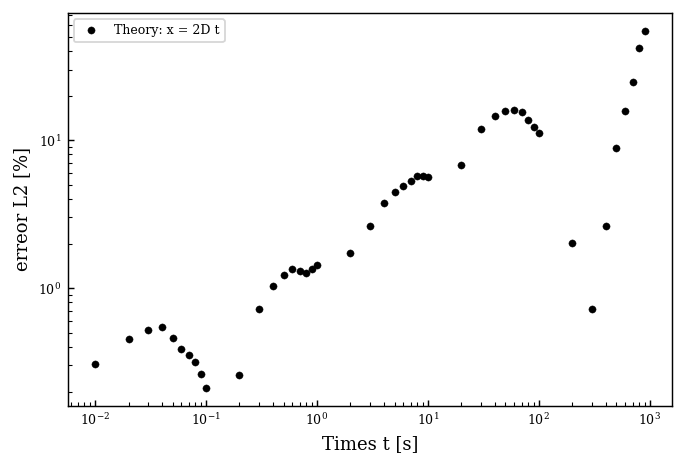

In [6]:
def normeErreurL2Relative(num, ana):
    f = (num - ana)**2/ana**2
    eL2 = np.sqrt(f) * 100
    
    return eL2

erreurL2MSDx = normeErreurL2Relative(MSDx, MSD1D)

plt.loglog(langevin3D.t[langevin3D.list_dt_MSD],
         erreurL2MSDx,
         "o", 
          markersize=4,
         color="black",
         label="Theory: x = 2D t",
        )
plt.xlabel("Times t [s]")
plt.ylabel("erreor L2 [%]")
plt.legend(fontsize='x-small', loc='upper left')
plt.show()

# erreurL2MSDy = normeErreurL2Relative(MSDy, MSD1D)
# print("Erreur L2 MSDy = ", erreurL2MSDy)

# erreurL2MSDz = normeErreurL2Relative(MSDz, MSD1D)
# print("Erreur L2 MSDz = ", erreurL2MSDz)

### I.3 Mean square displacement 3D

<font color='blue'> In 3D, MSD is compute like this :
\begin{equation}
<(\vec{x}(t+dt)-\vec{x}(t))^{2}> ~ = ~ <(x(t+dt)-x(t))^{2} ~ + ~ (y(t+dt)-y(t))^{2} ~ + ~ (z(t+dt)-z(t))^{2}>,
\end{equation}

as the coordinates are independent, we have:

\begin{equation}
<(\vec{x}(t+dt)-\vec{x}(t))^{2}> ~ = ~ <(x(t+dt)-x(t))^{2}> ~ + ~ <(y(t+dt)-y(t))^{2}> ~ + ~ <(z(t+dt)-z(t))^{2}>,
\end{equation}</font>



In [ ]:
langevin3D.MSD3D(plot=True)

<font color='blue'>Same here between $10^{2}$ and $10^{3}$.</font>


### I.4. Dx distribution

In [ ]:
# axis = "x"
# nbTimesIntervalle = [1, 10, 100]

# for i in nbTimesIntervalle:
#     hist, binsPosition = langevin3D.dXDistribution1D(axis, i, output=True)
#     plt.plot(binsPosition,hist, ".", label="$\Delta$ t = " + str(i*langevin3D.dt) + " s")
# plt.title("Probability density function 1D")
# plt.xlabel("$\\Delta$" + axis + " $[m]$")
# plt.ylabel("PDF $[m^{-1}.s]$")
# plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
# plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
# plt.legend()
# plt.show()

<font color='blue'> We can normalised speed by 

\begin{equation} 
\Delta x_{hist} = \frac{\Delta x}{\sqrt{2 D \Delta t }} 
\end{equation}

And we need to compute integrale between $] -\infty, +\infty[ $ to normalized y axis again.

Finaly, we can plot theory to compare :

\begin{equation} 
y_{theo} = \frac{1}{\sqrt{2 \pi}} e^{{- \frac{\Delta x_{hist}^{2}}{ 2} }}
\end{equation}

We can see next the result :</font>



In [ ]:
axis = "x"
nbTimesIntervalle = [1, 10, 100,1000]

for i in nbTimesIntervalle:
    hist, binsPosition = langevin3D.dXDistribution1D(axis, i, output=True)
    
    dx_hist = binsPosition/np.sqrt(2*langevin3D.D*langevin3D.dt*i)
    y_hist = hist
    normalisation_y = 1/np.trapz(y_hist,dx_hist)
    plt.plot(dx_hist,y_hist * normalisation_y, ".", label="$\Delta$ t = " + str(i*langevin3D.dt) + " s")

y_theo = 1/(np.sqrt(2*np.pi)) * np.exp(-(dx_hist**2)/2)
plt.plot(dx_hist, y_theo, "-", color="black", label="Theory")    
plt.title("Probability density function 1D")
plt.xlabel("Normalized $\\Delta$" + axis)
plt.ylabel("PDF")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.legend()
plt.show()

Non-inertial theory is avalayble for all times.

In [ ]:
w = cm2Inch(21 - 5)
h = cm2Inch((21 - 5)/1.618)
fig = plt.figure(constrained_layout=True, figsize=(w,h))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

###################################################
fig.add_subplot(spec[0, 0])

MSDx = langevin3D.MSD1D("x", output=True)
MSDy = langevin3D.MSD1D("y", output=True)
MSDz = langevin3D.MSD1D("z", output=True)

plt.loglog(langevin3D.t[langevin3D.list_dt_MSD],
            MSDx,
            "o", markersize=4,
            label="MSDx",
            )
plt.loglog(langevin3D.t[langevin3D.list_dt_MSD],
            MSDy,
            "o", markersize=4,
            label="MSDy",
            )
plt.loglog(langevin3D.t[langevin3D.list_dt_MSD],
            MSDz,
            "o", markersize=4,
            label="MSDz",
            )
plt.plot(langevin3D.t[langevin3D.list_dt_MSD],
         (2 * langevin3D.kb * langevin3D.T / langevin3D.gamma) * langevin3D.t[langevin3D.list_dt_MSD],
         linewidth=1,
         color="black",
         label="Theory: x = 2D t",
        )
plt.xlabel("Times t [s]")
plt.ylabel("MSD 1D [m²]")
plt.legend(fontsize='x-small', loc='upper left')

###################################################
fig.add_subplot(spec[0, 1])

MSD3D = langevin3D.MSD3D(output=True)


plt.loglog(langevin3D.t[langevin3D.list_dt_MSD], langevin3D.MSD3, "o", markersize=4, label="MSD3D ")
plt.plot(langevin3D.t[langevin3D.list_dt_MSD], (2 * 3 * langevin3D.kb * langevin3D.T / langevin3D.gamma) * langevin3D.t[langevin3D.list_dt_MSD], linewidth=1, color="black", label="Theory : x = 6D t")
plt.xlabel("Times t [s]")
plt.ylabel("MSD 3D [m²]")
plt.legend(fontsize='x-small', loc='upper left')


###################################################
fig.add_subplot(spec[1, 0])

axe = "x"
nbTimesIntervalle = [1, 10, 100]

for i in nbTimesIntervalle:
    hist, binsPosition = langevin3D.dXDistribution1D(axe, i, output=True)
    plt.plot(binsPosition,hist, "o", markersize=4, label="$\Delta$ t = " + str(i*langevin3D.dt) + " s")
plt.xlabel("$\\Delta$" + axis + " $[m]$")
plt.ylabel("PDF $[m^{-1}.s]$")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.legend(fontsize='x-small', loc='upper left')

###################################################
fig.add_subplot(spec[1, 1])

nbTimesIntervalle = [1, 10, 100]

for i in nbTimesIntervalle:
    hist, binsPosition = langevin3D.dXDistribution1D(axis, i, output=True)
    
    dx_hist = binsPosition/np.sqrt(2*langevin3D.D*langevin3D.dt*i)
    y_hist = hist
    normalisation_y = 1/np.trapz(y_hist,dx_hist)
    plt.plot(dx_hist,y_hist * normalisation_y, "o", markersize=4, label="$\Delta$ t = " + str(i*langevin3D.dt) + " s")

y_theo = 1/(np.sqrt(2*np.pi)) * np.exp(-(dx_hist**2)/2)
plt.plot(dx_hist, y_theo, "-", color="black", linewidth=1, label="Theory")
plt.xlabel("Normalized $\\Delta$" + axis)
plt.ylabel("PDF")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.legend(fontsize='xx-small', loc='upper left')


# plt.savefig("OverdampedBulk.svg")

## II. With inertia

<font color='blue'> Trajectory of a brownian particul with inertia is given by :

\begin{equation}
m \ddot{x} = - \gamma \dot{x} + \sqrt{2 k_b T \gamma} ~ dB_{t} 
\end{equation}

To compute it numericaly we can use finite difference given by :

\begin{equation}
m \frac{ x_i - 2x_{i-1} + x_{i-2} }{ \Delta t^{2} } x_{i-1} = - \gamma \frac{ x_i - x_{i-1} }{ \Delta t } + \sqrt{2 k_b T \gamma} ~~~ dB_t
\end{equation}

that give :

\begin{equation}
x_i = \frac{ 2 + \Delta t \frac{\gamma}{m} }{ 1 + \Delta t \frac{\gamma}{m} } x_{i-1} - \frac{ 1 }{ 1 + \Delta t \frac{\gamma}{m} } x_{i-2} + \frac{ \sqrt{2 k_b T \gamma} }{ m ( 1 + \Delta t \frac{\gamma}{m} ) } ~~ \Delta t^{2} dB_t
\end{equation}




$\underline{Creation~of~\textit{InertialLangevin3D}~class.}$

It heritate of $\textit{Langevin3D}$ (with its attributes and methodes),

$\textbf{Attribute add}$:

- rho : volumique masse of the particule, 

then we can calculate :

- m = rho * (4/3) * np.pi * R**3
- tau = m / gamma

$\textbf{Methode rewritten}$:

- trajectory(dt, Nt, R, rho, output=False)</font>




### II.1 Trajectories with inertia

In [ ]:
dt = 1e-9
Nt = 1500000
R = 1e-6
rho = 2626

inertial_langevin3D = InertialLangevin3D(dt, Nt, R, rho)
inertial_langevin3D.trajectory()
inertial_langevin3D.plotTrajectory()


### II.2 Mean square displacement 1D

In [ ]:
MSDx = inertial_langevin3D .MSD1D("x", output=True)
MSDy = inertial_langevin3D .MSD1D("y", output=True)
MSDz = inertial_langevin3D .MSD1D("z", output=True)

In [ ]:
plt.loglog(inertial_langevin3D.t[inertial_langevin3D.list_dt_MSD] / inertial_langevin3D.tau,
            MSDx,
            "*-",
            color="magenta",
            linewidth=1.0,
            label="Inertial MSDx",
            )
plt.plot(inertial_langevin3D.t[inertial_langevin3D.list_dt_MSD] / inertial_langevin3D.tau,
         (2 * inertial_langevin3D.kb * inertial_langevin3D.T / inertial_langevin3D.gamma) * inertial_langevin3D.t[inertial_langevin3D.list_dt_MSD],
         linewidth=1.2,
         color="black",
         label="Non-inertial: x = 2D t",
        )
plt.plot(inertial_langevin3D.t[inertial_langevin3D.list_dt_MSD] / inertial_langevin3D.tau,
         (inertial_langevin3D.kb * inertial_langevin3D.T / (inertial_langevin3D.m)) * inertial_langevin3D.t[inertial_langevin3D.list_dt_MSD]**2,
         linewidth=1.2,
         linestyle="--",
         color="black",
         label="Max-Boltz theory: x = $(k_b T / m) t^2$",
        )
plt.xlabel("Times $ t/ \\tau $")
plt.ylabel("MSD 1D [m²]")
plt.title("Mean square displacement 1D")
plt.legend()
plt.show()

<font color='blue'> We can see that the MSD is similar than the non-inertial theory after $t = \tau$.

Before $t = \tau$, inertial effect decrease the MSD below $x = 2Dt$,

where,
\begin{equation}
D =  \frac{k_b T}{\gamma} = \frac{k_b T}{6 \pi \eta R}
\end{equation}
    
because of ballistic regime we have $MSD_{1D} = \frac{k_b T}{m}~t^2 $ 
</font>





### II.3 Mean square displacement 3D

In [ ]:
MSD3D = inertial_langevin3D.MSD3D(output=True)

In [ ]:
plt.loglog(
        inertial_langevin3D.t[inertial_langevin3D.list_dt_MSD] / inertial_langevin3D.tau,
        MSD3D,
        "*-",
        color="purple",
        linewidth=1.4,
        label="Inertial MSD",
    )
plt.plot(
        inertial_langevin3D.t[inertial_langevin3D.list_dt_MSD] / inertial_langevin3D.tau,
        (6 * inertial_langevin3D.kb * inertial_langevin3D.T / inertial_langevin3D.gamma) * inertial_langevin3D.t[inertial_langevin3D.list_dt_MSD],
        color="black",
        linewidth=1.2,
        label="Non inertial theory : x = 6D t",
    )
plt.plot(inertial_langevin3D.t[inertial_langevin3D.list_dt_MSD] / inertial_langevin3D.tau,
         (3*inertial_langevin3D.kb * inertial_langevin3D.T / (inertial_langevin3D.m)) * inertial_langevin3D.t[inertial_langevin3D.list_dt_MSD]**2,
         linewidth=1.2,
         linestyle="--",
         color="black",
         label="Max-Boltz theory: x = $3(k_b T / m) t^2$",
        )
plt.xlabel("Times  $ t/ \\tau $")
plt.ylabel("MSD 3D [m²]")
plt.title("Mean square displacement 3D")
plt.legend()
plt.show()

<font color='blue'>We can see the same result in 3D. Before $t = \tau$, we have Maxwell-Boltzmann theory and after $t = \tau$, inertial MSD is the same than theory in non-inertial. </font>

### II.4. Speed distribution at short time

<font color='blue'>
At short times, inertial effect are predominant. We don't need to normalise because the speed doesn't depends of the time $\Delta t$. We have the same Maxwell-Boltzmann law for all $\Delta t < \tau$. This theoritical distribution (normalised) is:
    
\begin{equation}
p(v) = \sqrt{ \frac{m}{2 \pi k_b T} } ~ exp \left( - \frac{m}{k_b T} \frac{v^2}{2} \right) 
\end{equation}
</font>

In [ ]:
axis = "x"
nbTimesIntervalle = [1, 10, 100, 300]

m = inertial_langevin3D.m
kb = inertial_langevin3D.kb
T = inertial_langevin3D.T

for i in nbTimesIntervalle:
    hist, binsPosition = inertial_langevin3D.speedDistribution1D(axis, i, output=True)
    plt.plot(binsPosition,hist, ".", label="$\Delta$ t = {:.3f} $\\tau$".format(i*inertial_langevin3D.dt/inertial_langevin3D.tau))
    
    if i == nbTimesIntervalle[-1]:
        y_text =  np.max(hist)
    if i == nbTimesIntervalle[0]:
        x_text = np.min(binsPosition)

y_Max_boltzman = (m/(2*np.pi*kb*T))**(1/2) * np.exp(-(m*binsPosition**2)/(2*kb*T)) # Short time
        
plt.plot(binsPosition, y_Max_boltzman, "--", color="black", label="Maxwell-Boltzmann")
plt.text(x_text, y_text, "$\\tau$ = {:.2e} s".format(inertial_langevin3D.tau))
plt.title("Probability density function 1D at short times")
plt.xlabel("Speeds V" + axis + " $[m.s^{-1}]$")
plt.ylabel("PDF $[m^{-1}.s]$")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.legend( loc = 'upper right', markerscale = 1)
plt.axis([None, 3e-3, None, None])
plt.show()

### II.4 dX distribution at long time

<font color='blue'>Like in the first part, when ($t >> \tau$), we have :
    
\begin{equation} 
y_{theo} = \frac{1}{\sqrt{2 \pi}} e^{{- \frac{x_{list}^{2}}{ 2} }}
\end{equation}

where $\Delta x$ is normalised by :

\begin{equation} 
    \Delta x_{hist} = \frac{\Delta x}{\sqrt{2 D \Delta t }}
\end{equation}
 
and where we normalised the integral.
</font>



In [ ]:
axis = "x"
nbTimesIntervalle = [1000, 5000, 10000, 15000]

for i in nbTimesIntervalle:
    hist, binsPosition = inertial_langevin3D.dXDistribution1D(axis, i, bins=30, output=True)
    
    dx_hist = binsPosition/np.sqrt(2*inertial_langevin3D.D*inertial_langevin3D.dt*i)
    y_hist = hist
    normalisation_y = 1/np.trapz(y_hist,dx_hist)
    
    plt.plot(dx_hist,y_hist * normalisation_y, "*", label="$\Delta$ t = {:.1f} $\\tau$".format(i*inertial_langevin3D.dt/inertial_langevin3D.tau))

    if i == nbTimesIntervalle[0]:
        y_text =  np.max(y_hist* normalisation_y)
    if i == nbTimesIntervalle[-1]:
        x_text = np.min(dx_hist)
    
y_theo = 1/(np.sqrt(2*np.pi)) * np.exp(-(dx_hist**2)/2)

plt.text(x_text, y_text, "$\\tau$ = {:.2e} s".format(inertial_langevin3D.tau))
plt.plot(dx_hist, y_theo, "-", color="black", label="Non-inertial theory")
plt.title("Probability density function 1D at long times")
plt.xlabel("Normalized $\\Delta$" + axis)
plt.ylabel("PDF")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.legend(loc='upper right', fontsize='x-small')
plt.show()

<font color='blue'> We can see that when $t > \tau$ but close to $\tau$, the non inertial theory does'nt work again (blue and orange curves). But at long times ($t >> \tau$), the PDF (green and red) fit with the non-inertial theory.
    
    
To conclude, at short times ($t << \tau$) we have Maxwell-boltzmann law because of the inertial effect and at long times ($t >> \tau$), inertial effect disappears and non-inertial law fit.
</font>

### II.5 Autocorelation at short times

<font color='blue'> 
We can compute the speed autocorelation at short time:
</font>

In [ ]:
inertial_langevin3D.speedDistribution1D(axis="x")
speed = inertial_langevin3D.speed
x_cor = speed - np.mean(speed)
autoco = correlate(x_cor, x_cor, mode='same')

t_cor = inertial_langevin3D.t[:-1]-np.mean(inertial_langevin3D.t[:-1])

In [ ]:
plt.plot(t_cor/inertial_langevin3D.tau, autoco/np.max(autoco))
plt.title("Speed autocorrelation in inertial")
plt.xlabel("Times $t / \\tau$")
plt.ylabel("$C_{v}(t)$")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.axis([-4.5, 4.5, 0, None])
plt.show()

<font color='blue'> We can see that at $t=0$, speed is correlated. Then the correlation decrease until $t = 3.5 \tau$ and after that, when $t >> \tau$, speed is anti-correlated. That show the inertial effects at short time $t <= \tau$. The particules have memories for the begining of the trajectory and after that back to brownian motion after $t = 3.5 \tau$.
</font>